## **Stratification**

In [2]:
import os
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy import stats

### Data Generation

Для простоты будем считать, что у нас две страты, которые представлены в **одинаковых** пропорциях в генеральной совокупности.
Напишем функции генерирования данных для случайного и стратифицированного сэмплирования:


In [53]:
def generate_random_data(sample_size, mean_one, mean_two, std=1):
    """Генерируем две выборки с случайным сэмплированием.
    
    sample_size - размер выборки
    mean_one, mean_two - средние значения в стратах
    std - среднеквадратичное отклонение
    
    return - [df_one, df_two], пара pd.DataFrame со столбцами ['strat', 'metric'],
        где столбце 'strat' содержится идентификатор страты, а в 'metric' - значения метрики.
    """
    df_one = pd.DataFrame({'strat': 0, 'metric': np.random.normal(mean_one, std, sample_size)})
    df_two = pd.DataFrame({'strat': 1, 'metric': np.random.normal(mean_two, std, sample_size)})
    df = pd.concat([df_one, df_two], ignore_index=True).sample(sample_size * 2) #  делает перемешивание всех строк, потому что 
    # по умолчанию sample() возвращает случайную выборку из датафрейма. 
    # А если ты указал размер выборки равный общему количеству строк, это просто перетасовка (shuffle). Эквивалент random.shuffle() для датафрейма.
    # print(df)
    dfs = [df.iloc[:sample_size].copy(), df.iloc[sample_size:].copy()]
    return dfs

def generate_stratified_data(sample_size, mean_one, mean_two, std=1):
    """Генерируем две выборки с стратифицированным сэмплированием.
    
    sample_size - размер выборки
    mean_one, mean_two - средние значения в стратах
    std - среднеквадратичное отклонение
    
    return - [df_one, df_two], пара pd.DataFrame со столбцами ['strat', 'metric'],
        где столбце 'strat' содержится идентификатор страты, а в 'metric' - значения метрики.
    """
    size_strata_one = int(sample_size / 2)
    size_strata_two = sample_size - size_strata_one
    dfs = []
    for _ in range(2):
        metric = np.hstack([
            np.random.normal(mean_one, std, size_strata_one),
            np.random.normal(mean_two, std, size_strata_two)
        ])
        strat = np.hstack([
            np.zeros(size_strata_one),
            np.ones(size_strata_two)
        ]).astype(int)
        df = pd.DataFrame({'strat': strat, 'metric': metric})
        dfs.append(df)
    return dfs

In [50]:
sample_size = 6
mean_one = 5
mean_two = 10

dfs_srs = generate_random_data(sample_size, mean_one, mean_two)
dfs_srs[0]

,strat,metric
4,0,3.527699
11,1,10.636362
9,1,11.813315
5,0,5.856362
1,0,7.122032
8,1,10.301303


In [49]:
dfs_strat = generate_stratified_data(sample_size, mean_one, mean_two)
dfs_strat

[    strat     metric
 0       0   6.564200
 1       0   4.957700
 2       0   4.179561
 3       0   7.204261
 4       0   3.780312
 ..    ...        ...
 95      1   9.093705
 96      1   9.537121
 97      1  10.076160
 98      1   9.454121
 99      1  10.383825
 
 [100 rows x 2 columns],
     strat     metric
 0       0   2.562491
 1       0   5.599560
 2       0   4.861104
 3       0   5.161500
 4       0   6.009786
 ..    ...        ...
 95      1  10.121901
 96      1  10.317567
 97      1  10.043423
 98      1   9.551586
 99      1  11.376612
 
 [100 rows x 2 columns]]

### Mean Calculation

Нам необходимо оценить популяционное среднее бизнес метрики $Y$.

1. $\mu = \mathbb{E} Y$ – популяционное среднее

2. $\sigma^2 = \mathbb{V} Y$ – популяционная дисперсия

3. $\mu_k$, $\sigma_k^2$ – среднее значение и дисперсия бизнес метрики для $k$-й страты

4. $w_k$ – доля $k$-й страты в популяции

5. $n_k$ – число пользователей из $k$-й страты в рассматриваемой группе

6. $n = \sum_{k=1}^K n_k$ – общий размер группы

7. $Y_{11},\ldots Y_{1n_1},\ldots Y_{K1},\ldots Y_{Kn_K}$ – выборка из г.с., 
    где $Y_{kj}$ - метрика для $j$-го пользователя $k$-й страты

Для популяционного среднего можно рассмотреть две несмещенные точечные оценки:

1. **Простое среднее**
$$\overline{Y} = \frac{1}{n} \sum_{k=1}^K \sum_{j=1}^{n_k} Y_{kj} = \frac{1}{n} \sum_{i=1}^n Y_i$$ 

2. **Взвешенное среднее (стратифицированное среднее)**
$$ \hat{Y}_{strat} = \sum_{k=1}^K w_k \overline{Y}_k, \quad
\overline{Y}_k = \frac{1}{n_k} \sum_{j=1}^{n_k} Y_{kj}$$

In [55]:
def calculate_mean(df):
    """Вычисляет обычное среднее по столбцу 'metric'."""
    return df['metric'].mean()


def calculate_stratified_mean(df, weights):
    """Вычисляет стратифицированное среднее.

    df - DataFrame с целевой метрикой и данными для стратификации
    weights - dict - {название страты: вес страты}

    return: float, mean_strat
    """
    # print(df)
    # print(f"weight\n{weights}")
    strat_mean = df.groupby('strat')['metric'].mean()
    df_means_weights = pd.merge(
        strat_mean,
        pd.Series(weights, name='weight'),
        how='inner',
        left_index=True,
        right_index=True
    )
    # если в данных df не было каких-то страт, то часть weights затрётся и сумма весов будет меньше 1
    df_means_weights['weight'] = df_means_weights['weight'] / df_means_weights['weight'].sum()

    mean_strat = (df_means_weights['weight'] * df_means_weights['metric']).sum()
    return mean_strat

  0%|          | 0/3000 [00:00<?, ?it/s]

mean(means) = 7.50, mean(strat_means) = 7.50


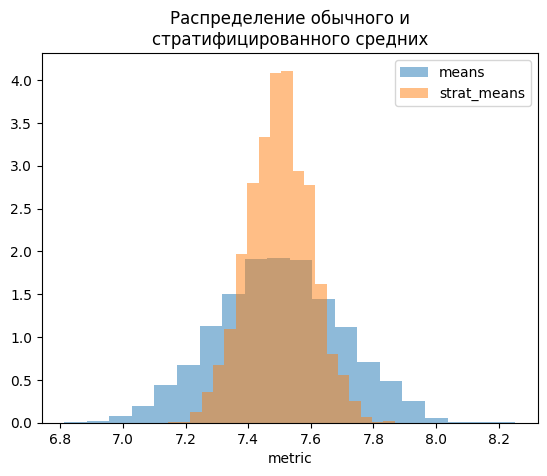

In [38]:
sample_size = 100
mean_one = 5
mean_two = 10
weights = {0: 0.5, 1: 0.5}


means = []
strat_means = []
for _ in tqdm(range(3000)):
    df = generate_random_data(sample_size, mean_one, mean_two)[0]
    means.append(calculate_mean(df))
    strat_means.append(calculate_stratified_mean(df, weights))


print(f'mean(means) = {np.mean(means):0.2f}, mean(strat_means) = {np.mean(strat_means):0.2f}')

plt.hist(means, bins=20, alpha=0.5, density=True, label='means')
plt.hist(strat_means, bins=20, alpha=0.5, density=True, label='strat_means')
plt.xlabel('metric')
plt.title('Распределение обычного и\nстратифицированного средних')
plt.legend()
plt.show()

- получили распределения с близкими средними
- разброс у стратифицированного среднего меньше

### Stratification Types

**Стратификация:**
стратифицированное семплирование $STRAT$ + Взвешенное среднее

**Постстратификация:**
случайное семплирование $SRS$ + Взвешенное среднее

**Без стратификации:**
случайное семплирование $SRS$ + Простое среднее

1. **Простое среднее**
$$\overline{Y} = \frac{1}{n} \sum_{k=1}^K \sum_{j=1}^{n_k} Y_{kj} = \frac{1}{n} \sum_{i=1}^n Y_i$$ 

2. **Взвешенное среднее (стратифицированное среднее)**
$$ \hat{Y}_{strat} = \sum_{k=1}^K w_k \overline{Y}_k, \quad
\overline{Y}_k = \frac{1}{n_k} \sum_{j=1}^{n_k} Y_{kj}$$

### Variance

#### Dependence on Sample Size

Будем увеличивать размер выборок и для каждого размера выборки вычислять оценку среднего несколько раз, 
чтобы затем оценить разброс:


[5, 10, 15, 20, 50, 80]


  0%|          | 0/6 [00:00<?, ?it/s]

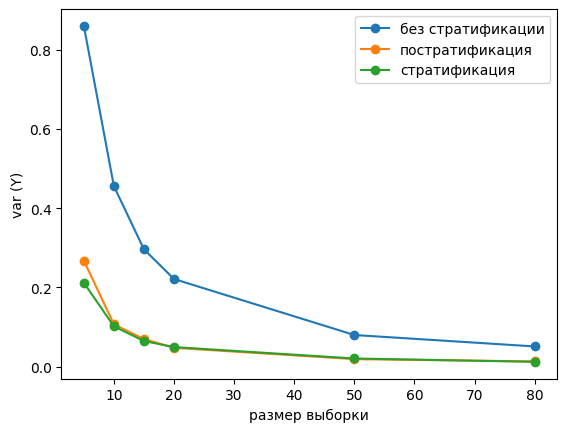

In [56]:
mean_one = 0
mean_two = 5
weights = {0: 0.5, 1: 0.5}
sample_sizes = [5, 10, 15] + list(range(20, 81, 30))
print(sample_sizes)

var_random_means = []
var_poststratified_means = []
var_stratified_means = []

for sample_size in tqdm(sample_sizes):
    random_means = []
    poststratified_means = []
    stratified_means = []
    for _ in range(1000):
        df_srs = generate_random_data(sample_size, mean_one, mean_two)[0]
        df_strat = generate_stratified_data(sample_size, mean_one, mean_two)[0]
        random_means.append(calculate_mean(df_srs))
        poststratified_means.append(calculate_stratified_mean(df_srs, weights))
        stratified_means.append(calculate_stratified_mean(df_strat, weights))
    var_random_means.append(np.var(random_means))
    var_poststratified_means.append(np.var(poststratified_means))
    var_stratified_means.append(np.var(stratified_means))

plt.plot(sample_sizes, var_random_means, '-o', label='без стратификации')
plt.plot(sample_sizes, var_poststratified_means, '-o', label='постратификация')
plt.plot(sample_sizes, var_stratified_means, '-o', label='стратификация')
plt.xlabel('размер выборки')
plt.ylabel('var (Y)')
plt.legend()
plt.show()

- при увеличении sample_size дисперсия при постстратификации быстро приближается к дисперсии при стратификации
- отличия дисперсий всех способов при увеличении sample_size уменьшаются

#### Dependence on Difference Between Stratas' Means

Проведём аналогичный эксперимент, только теперь будем увеличивать среднее значение метрики у второй страты:


  0%|          | 0/6 [00:00<?, ?it/s]

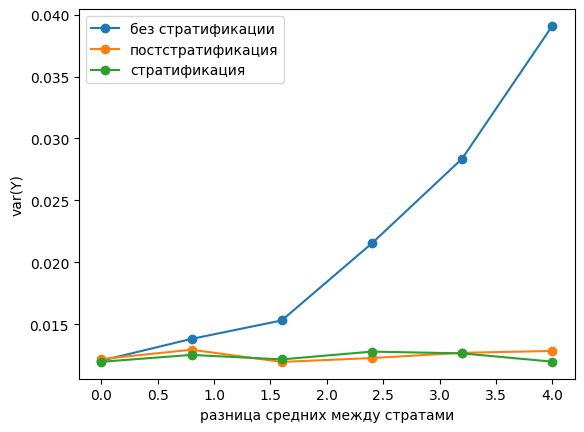

In [57]:
mean_one = 0
array_mean_two = np.linspace(0, 4, 6)
weights = {0: 0.5, 1: 0.5}
sample_sizes = 10

var_random_means = []
var_poststratified_means = []
var_stratified_means = []

for mean_two in tqdm(array_mean_two):
    random_means = []
    poststratified_means = []
    stratified_means = []
    for _ in range(1000):
        df_srs = generate_random_data(sample_size, mean_one, mean_two)[0]
        df_strat = generate_stratified_data(sample_size, mean_one, mean_two)[0]
        random_means.append(calculate_mean(df_srs))
        poststratified_means.append(calculate_stratified_mean(df_srs, weights))
        stratified_means.append(calculate_stratified_mean(df_strat, weights))
    var_random_means.append(np.var(random_means))
    var_poststratified_means.append(np.var(poststratified_means))
    var_stratified_means.append(np.var(stratified_means))

plt.plot(array_mean_two, var_random_means, '-o', label='без стратификации')
plt.plot(array_mean_two, var_poststratified_means, '-o', label='постстратификация')
plt.plot(array_mean_two, var_stratified_means, '-o', label='стратификация')
plt.xlabel('разница средних между стратами')
plt.ylabel('var(Y)')
plt.legend()
plt.show()

- при увеличении отличий между стратами дисперсия без использования стратификации увеличивается
- изменение отличий между стратами не влияют на дисперсию при использовании стратификации и постстратификации
- при отсутствии отличий между стратами, дисперсии всех трёх методов совпадают

### Experiment Evaluation


In [61]:
def check_test(df_control, df_pilot):
    """Проверяет гипотезу о равенстве средних для обычного среднего.
    
    return - pvalue.
    """
    values_control = df_control['metric'].values
    values_pilot = df_pilot['metric'].values
    _, pvalue = stats.ttest_ind(values_control, values_pilot)
    return pvalue


def calculate_strat_var(df, weights):
    """Вычисляет стратифицированную дисперсию."""
    strat_vars = df.groupby('strat')['metric'].var()
    df_vars_weights = pd.merge(
        strat_vars,
        pd.Series(weights, name='weight'),
        how='inner',
        left_index=True,
        right_index=True
    )
    # если в данных df не было каких-то страт, то часть weights затрётся и сумма весов будет меньше 1
    df_vars_weights['weight'] = df_vars_weights['weight'] / df_vars_weights['weight'].sum()
    var_strat = (df_vars_weights['weight'] * df_vars_weights['metric']).sum()
    return var_strat


def check_stratified_test(df_control, df_pilot, weights):
    """Проверяет гипотезу о равенстве средних для стратифицированного среднего.
    
    return - pvalue.
    """
    mean_strat_control = calculate_stratified_mean(df_control, weights)
    mean_strat_pilot = calculate_stratified_mean(df_pilot, weights)
    var_strat_control = calculate_strat_var(df_control, weights)
    var_strat_pilot = calculate_strat_var(df_pilot, weights)
    delta_mean_strat = mean_strat_pilot - mean_strat_control
    std_mean_strat = (var_strat_pilot / len(df_pilot) + var_strat_control / len(df_control)) ** 0.5
    t = delta_mean_strat / std_mean_strat
    pvalue = (1 - stats.norm.cdf(np.abs(t))) * 2
    return pvalue

Проверим что `check_stratified_test` работает корретно. 
Для этого применим к данным с одной стратой функции `check_stratified_test` и `check_test`. 
Результаты должны быть примерно одинаковы.

In [65]:
size = 10000
df_one = pd.DataFrame({'strat': 1, 'metric': np.random.normal(0, 1, size)})
df_two = pd.DataFrame({'strat': 1, 'metric': np.random.normal(0.01, 1, size)})

check_test(df_one, df_two), check_stratified_test(df_one, df_two, weights)

(0.04260500062744156, 0.0425917678685257)

#### Evaluation of Probabilities of Type I Errors

Проведём много A/A тестов и построим распределение p-value. p-value должно быть распределено равномерно:


  0%|          | 0/1000 [00:00<?, ?it/s]

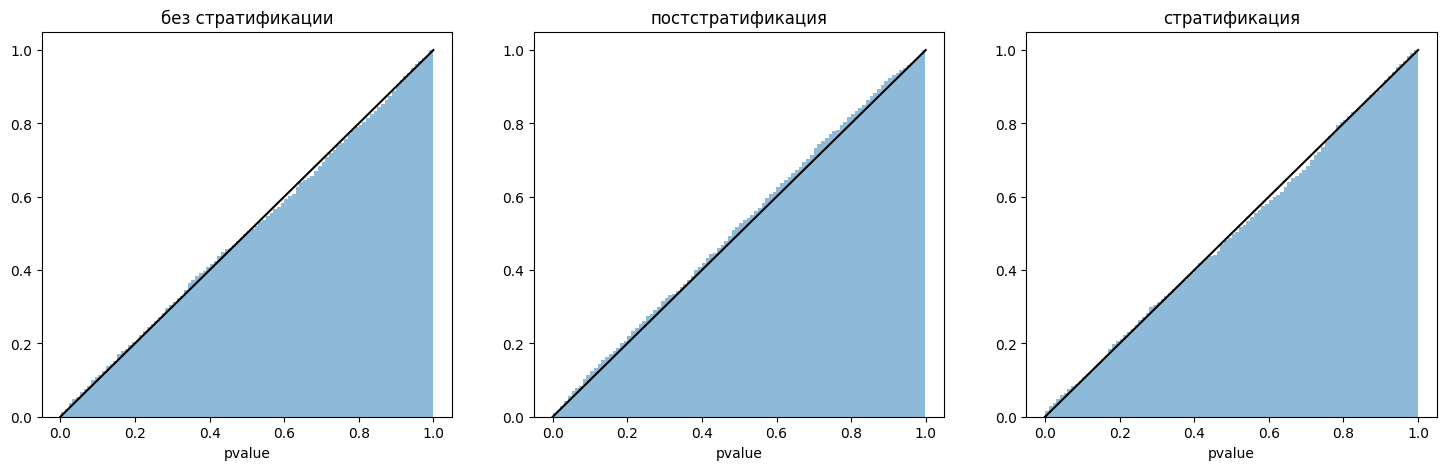

In [66]:
mean_one = 0
mean_two = 2
weights = {0: 0.5, 1: 0.5}
sample_sizes = 1000

pvalues_random = []
pvalues_poststratified = []
pvalues_stratified = []

for _ in tqdm(range(1000)):
    dfs_srs = generate_random_data(sample_size, mean_one, mean_two)
    dfs_strat = generate_stratified_data(sample_size, mean_one, mean_two)

    pvalues_random.append(check_test(*dfs_srs))
    pvalues_poststratified.append(check_stratified_test(*dfs_srs, weights))
    pvalues_stratified.append(check_stratified_test(*dfs_strat, weights))


_, axes = plt.subplots(1, 3, figsize=[18, 5])
list_pvalues = [pvalues_random, pvalues_poststratified, pvalues_stratified]
list_titles = ['без стратификации', 'постстратификация', 'стратификация']

for ax, pvalues, title in zip(axes, list_pvalues, list_titles):
    ax.hist(pvalues, bins=100, density=True, cumulative=True, alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel('pvalue')
    ax.plot([0, 1], [0, 1], 'k')
plt.show()

p-value распределено равномерно, все три способа показывают корректные результаты.

#### Comparing the Experiments' Power

Проведём много A/B тестов и построим распределение p-value. 
Распределение p-value должно быть выпуклым вверх. 
Чем более выпуклое, тем мощнее тест.

  0%|          | 0/1000 [00:00<?, ?it/s]

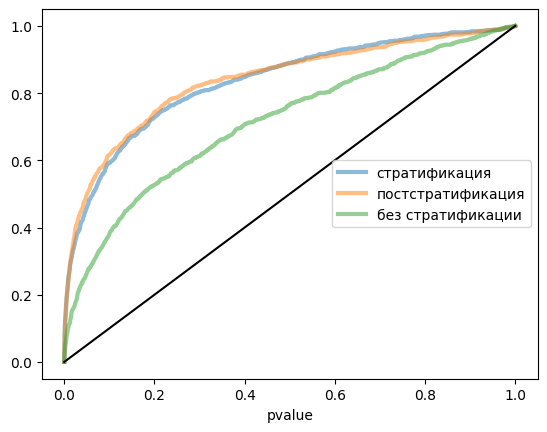

In [67]:
mean_one = 0
mean_two = 2
weights = {0: 0.5, 1: 0.5}
sample_sizes = 1000

pvalues_random = []
pvalues_poststratified = []
pvalues_stratified = []

for _ in tqdm(range(1000)):
    dfs_srs = generate_random_data(sample_size, mean_one, mean_two)
    dfs_strat = generate_stratified_data(sample_size, mean_one, mean_two)

    # add effect
    effect = np.random.normal(0.3, 0.1, sample_size)
    dfs_srs[1]['metric'] += effect
    dfs_strat[1]['metric'] += effect
    
    pvalues_random.append(check_test(*dfs_srs))
    pvalues_poststratified.append(check_stratified_test(*dfs_srs, weights))
    pvalues_stratified.append(check_stratified_test(*dfs_strat, weights))


list_pvalues = [pvalues_random, pvalues_poststratified, pvalues_stratified]
list_titles = ['без стратификации', 'постстратификация', 'стратификация']

X = np.linspace(0, 1, 1000)
for pvalues, title in zip(reversed(list_pvalues), reversed(list_titles)):
    pvalues = np.array(pvalues)
    Y = [np.mean(pvalues < x) for x in X]
    plt.plot(X, Y, alpha=0.5, linewidth=3, label=title)
plt.xlabel('pvalue')
plt.plot([0, 1], [0, 1], 'k')
plt.legend(loc=5)
plt.show()

Методы с использованием стратификации обладают большей мощностью, а значит и большей чувствительностью.

### Pizzeria's Data

Посмотрим, как работает стратификация на примере данных пиццерии.

In [68]:
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/'

def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

df_sales = read_database('2022-04-01/2022-04-01T12_df_sales.csv')
df_sales['date'] = pd.to_datetime(df_sales['date'])
df_user_strats = read_database('user_strats.csv')

df_sales - информация о покупках, одна строка - один заказ. Атрибуты:
- sale_id - идентификатор покупки;
- date - дата покупки;
- count_pizza - количество пицц в заказе;
- count_drink - количество напитков в заказе;
- price - стоимость заказа;
- user_id - идентификатор пользователя.

In [69]:
df_sales.head()

,sale_id,date,count_pizza,count_drink,price,user_id
0,1000001,2022-02-04 10:00:24,1,0,720,1c1543
1,1000002,2022-02-04 10:02:28,1,1,930,a9a6e8
2,1000003,2022-02-04 10:02:35,3,1,1980,23420a
3,1000004,2022-02-04 10:03:06,1,1,750,3e8ed5
4,1000005,2022-02-04 10:03:23,1,1,870,cbc468


Описание страт:
- 1 — заходят только с мобильного устройства;
- 2 — заходят только с компьютера;
- 3 — заходят и с мобильного, и с компьютера.


In [70]:
df_user_strats.head()

,user_id,strat
0,000096,1
1,0000d4,1
2,0000de,1
3,0000e4,1
4,0000e7,1


#### Количество пользователей в стратах

In [71]:
df_user_strats['strat'].value_counts()

strat
1    58285
3    53518
2    11644
Name: count, dtype: int64

In [74]:
# считаем значения метрики
begin_date = datetime(2022, 3, 23)
end_date = datetime(2022, 3, 30)
df_metrics = (
    df_sales
    [(df_sales['date'] >= begin_date) & (df_sales['date'] < end_date)]
    .groupby('user_id')[['price']].sum()
    .rename(columns={'price': 'metric'})
    .reset_index()  
)

df_metrics = pd.merge(df_metrics, df_user_strats, on='user_id', how='left')
df_metrics.head(7)

,user_id,metric,strat
0,0000d4,720,1
1,0000de,660,1
2,0000e4,840,1
3,0001e2,2430,1
4,0001ff,720,1
5,00028b,1260,3
6,000964,1980,1


Посмотрим, как отличаются средние значения между стратами

In [75]:
df_metrics.groupby('strat')[['metric']].mean()

,metric
strat,
1,1221.697525
2,1251.554174
3,1227.406882


Отличия небольшие. Посмотрим, поможет ли постстратификация увеличить чувствительность теста.

  0%|          | 0/1000 [00:00<?, ?it/s]

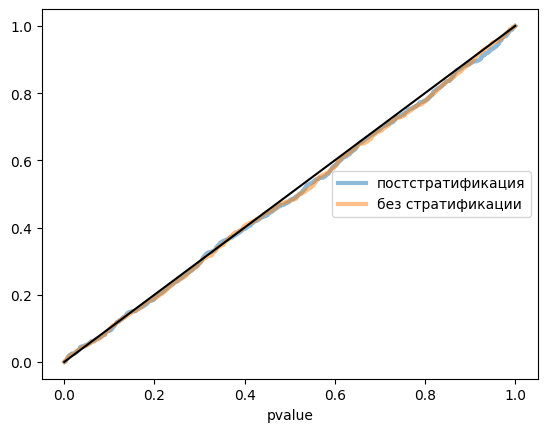

In [78]:
sample_size = 1000
weights = df_user_strats['strat'].value_counts(normalize=True).to_dict() # {1: 0.472145941173135, 3: 0.4335301789431902, 2: 0.09432387988367477}
effect = 0 

pvalues_random = []
pvalues_poststratified = []

for _ in tqdm(range(1000)):
    control_users, pilot_users = np.random.choice(df_metrics['user_id'].values, (2, sample_size), False)
    df_control = df_metrics[df_metrics['user_id'].isin(control_users)].copy()
    df_pilot = df_metrics[df_metrics['user_id'].isin(pilot_users)].copy()
    df_pilot['metric'] += effect
    pvalues_random.append(check_test(df_control, df_pilot))
    pvalues_poststratified.append(check_stratified_test(df_control, df_pilot, weights))

list_pvalues = [pvalues_random, pvalues_poststratified]
list_titles = ['без стратификации', 'постстратификация']

X = np.linspace(0, 1, 1000)
for pvalues, title in zip(reversed(list_pvalues), reversed(list_titles)):
    pvalues = np.array(pvalues)
    Y = [np.mean(pvalues < x) for x in X]
    plt.plot(X, Y, alpha=0.5, linewidth=3, label=title)
plt.xlabel('pvalue')
plt.plot([0, 1], [0, 1], 'k')
plt.legend(loc=5)
plt.show()

В данном примере с данными пиццерии отличия невооружённым глазом незаметны.

### Разбиение объектов на страты (уменьшение дисперсии стратифицированного среднего)

In [ ]:
# Предположим, у нас есть набор признаков, которые вычисляются независимо от эксперимента.
# Используя эти признаки, разбъем объекты на страты так, 
# чтобы дисперсия стратифицированного среднего была минимальна и доля каждой страты была не менее 5% от всех данных.

# Данные разбиты на 2 части. Первая часть доступна для исследования по ссылке stratification_task_data_public.csv. 
# Решение будет проверяться на второй части данных. Значения в столбцах 
# x1, ..., x10 — признаки, которые можно использовать для вычисления страт. 
# Значения в столбце y — измерения, по которым будет вычисляться целевая метрика эксперимента.

import pandas as pd
import numpy as np


def get_strats(df: pd.DataFrame):
    """Возвращает страты объектов.
    
    :return (list | np.array | pd.Series): список страт объектов размера len(df).
    """
    # print(df['x4'].unique()) # [0 2 1]
    for i in df.index:
        if df['x4'][i] == 0 and df['x8'][i] == 0:
            df.loc[i, 'strat'] = 1
        elif df['x4'][i] == 0 and df['x8'][i] == 1:
            df.loc[i, 'strat'] = 2
        elif df['x4'][i] == 1 and df['x8'][i] == 0:
            df.loc[i, 'strat'] = 3
        elif df['x4'][i] == 1 and df['x8'][i] == 1:
            df.loc[i, 'strat'] = 4
        elif df['x4'][i] == 2 and df['x8'][i] == 0:
            df.loc[i, 'strat'] = 5
        elif df['x4'][i] == 2 and df['x8'][i] == 1:
            df.loc[i, 'strat'] = 6

        return df['strat']


def calculate_strat_var(df):
    """Вычисляет стратифицированную дисперсию популяции."""
    strat_vars = df.groupby('strat')['y'].var()
    weights = df['strat'].value_counts(normalize=True)
    stratified_var = (strat_vars * weights).sum()
    return stratified_var


if __name__ == "__main__":
    bound = 50000
    df = pd.read_csv('../data/stratification_task_data_public.csv')
    strats = get_strats(df.drop('y', axis=1))
    assert len(strats) == len(df), "Неверный размер списка страт"
    min_part = pd.Series(strats).value_counts(normalize=True).min()
    assert min_part >= 0.05, "Минимальная доля одной из страт меньше 5%"
    df['strat'] = strats
    strat_var = calculate_strat_var(df)
    err_msg = f"Дисперсия равна {strat_var:0.1f}, её нужно снизить до {bound}"
    assert strat_var <= bound, err_msg
    print(f'Отлично! Дисперсия равна {strat_var:0.1f}, меньше порога {bound}')

Отлично! Дисперсия равна 0.0, меньше порога 50000


### Функция split_stratified - распределение по группам(контрольная и экспериментальная)

In [ ]:
# Допустим, мы заранее определили множество клиентов, которые будут участвовать в эксперименте. 
# Их страты известны. Нужно написать функцию, которая будет стратифицировано распределять их по группам.

# Распределение по группам будем считать стратифицированным, если для каждой страты количество клиентов 
# этой страты в группах отличаются не более, чем на 1.

def split_stratified(strats: np.array) -> np.array:
    """Распределяет объекты по двум группам (0 — контрольная, 1 — экспериментальная)
    с соблюдением стратификации: в каждой страте размеры групп отличаются не более чем на 1.
    """
    # Получаем массив индексов от 0 до len(strats) - 1
    indexes = np.arange(len(strats))
    
    # Создаём списки для индексов объектов, попавших в каждую из двух групп
    a_indexes = []  # группа 0 (контрольная)
    b_indexes = []  # группа 1 (экспериментальная)
    
    # Перебираем каждую уникальную страту в данных
    for strat in np.unique(strats):
        # Получаем индексы всех объектов, принадлежащих текущей страте
        indexes_strat = indexes[strats == strat]
        
        # Считаем количество объектов в этой страте
        size_strat = len(indexes_strat)
        
        # Перемешиваем индексы в текущей страте для случайного распределения
        np.random.shuffle(indexes_strat)
        
        # Делим страты на две группы:
        # - Первую половину (округление вниз) добавляем в группу A
        # - Вторую половину — в группу B
        # Это позволяет сбалансировать страты: если нечётное число, то разница будет максимум 1
        a_indexes += list(indexes_strat[:size_strat // 2])
        b_indexes += list(indexes_strat[size_strat // 2:])
    
    # Инициализируем массив с нулями (все объекты по умолчанию в группе 0)
    groups = np.zeros(len(strats), dtype=int)
    
    # Индексы из группы B помечаем как 1 (экспериментальная группа)
    groups[b_indexes] = 1
    
    return groups


def check_split(df: pd.DataFrame):
    """Проверяет корректность разбиения на страты.
    
    :param df: датафрейм с двумя столбцами: ['strat', 'group'].
    """
    df_agg = (
        df
        .groupby(['strat', 'group'])[['group']].count()
        .rename(columns={'group': 'count'})
        .reset_index()
    )
    df_pivot = df_agg.pivot(index='strat', values='count', columns='group')
    max_delta = (df_pivot[0] - df_pivot[1]).abs().max()
    assert max_delta <= 1, "Размеры страт между группами отличаются более чем на 1."


if __name__ == "__main__":
    df = pd.DataFrame({'strat': [1, 2, 2, 2, 1, 1, 1, 3, 3]})
    df['group'] = split_stratified(df['strat'].values)
    check_split(df)
    print('simple test passed')


simple test passed


### Метод _ttest_strat класса ExperimentsService (функция для оценки эксперимента с применением постстратификации)

In [ ]:
import numpy as np
import pandas as pd
from pydantic import BaseModel
from scipy import stats


class Design(BaseModel):
    """Дата-класс с описание параметров эксперимента.

    statistical_test - тип статтеста. ['ttest', 'bootstrap']
    effect - размер эффекта в процентах
    alpha - уровень значимости
    beta - допустимая вероятность ошибки II рода
    stratification - постстратификация. 'on' - использовать постстратификация, 'off - не использовать.
    """
    statistical_test: str = 'ttest'
    effect: float = 3.
    alpha: float = 0.05
    beta: float = 0.1
    stratification: str = 'off'


class ExperimentsService:

    @staticmethod
    def _calc_strat_mean(df: pd.DataFrame, weights: pd.Series) -> float:
        """Считает стратифицированное среднее.

        :param df: датафрейм с целевой метрикой и данными для стратификации
        :param weights: маппинг {название страты: вес страты в популяции}
        """
        strat_mean = df.groupby('strat')['metric'].mean()
        return (strat_mean * weights).sum()

    @staticmethod
    def _calc_strat_var(df: pd.DataFrame, weights: pd.Series) -> float:
        """Считает стратифицированную дисперсию.

        :param df: датафрейм с целевой метрикой и данными для стратификации
        :param weights: маппинг {название страты: вес страты в популяции}
        """
        strat_var = df.groupby('strat')['metric'].var()
        return (strat_var * weights).sum()

    def _ttest_strat(self, metrics_strat_a_group, metrics_strat_b_group):
        """Применяет постстратификацию, возвращает pvalue.

        Веса страт считаем по данным обеих групп.
        Предполагаем, что эксперимент проводится на всей популяции.
        Веса страт нужно считать по данным всей популяции.

        :param metrics_strat_a_group (np.ndarray): значения метрик и страт группы A.
            shape = (n, 2), первый столбец - метрики, второй столбец - страты.
        :param metrics_strat_b_group (np.ndarray): значения метрик и страт группы B.
            shape = (n, 2), первый столбец - метрики, второй столбец - страты.
        :param design (Design): объект с данными, описывающий параметры эксперимента
        :return (float): значение p-value
        """
        weights = (
            pd.Series(np.hstack((metrics_strat_a_group[:, 1], metrics_strat_b_group[:, 1],)))
            .value_counts(normalize=True)
        )
        # print(weights)
        a = pd.DataFrame(metrics_strat_a_group, columns=['metric', 'strat'])
        b = pd.DataFrame(metrics_strat_b_group, columns=['metric', 'strat'])
        a_strat_mean = self._calc_strat_mean(a, weights)
        b_strat_mean = self._calc_strat_mean(b, weights)
        a_strat_var = self._calc_strat_var(a, weights)
        b_strat_var = self._calc_strat_var(b, weights)
        delta = b_strat_mean - a_strat_mean
        std = (a_strat_var / len(a) + b_strat_var / len(b)) ** 0.5
        t = delta / std
        pvalue = 2 * (1 - stats.norm.cdf(np.abs(t)))
        return pvalue

    def get_pvalue(self, metrics_strat_a_group, metrics_strat_b_group, design):
        """Применяет статтест, возвращает pvalue.

        :param metrics_strat_a_group (np.ndarray): значения метрик и страт группы A.
            shape = (n, 2), первый столбец - метрики, второй столбец - страты.
        :param metrics_strat_b_group (np.ndarray): значения метрик и страт группы B.
            shape = (n, 2), первый столбец - метрики, второй столбец - страты.
        :param design (Design): объект с данными, описывающий параметры эксперимента
        :return (float): значение p-value
        """
        if design.statistical_test == 'ttest':
            if design.stratification == 'off':
                _, pvalue = stats.ttest_ind(metrics_strat_a_group[:, 0], metrics_strat_b_group[:, 0])
                return pvalue
            elif design.stratification == 'on':
                return self._ttest_strat(metrics_strat_a_group, metrics_strat_b_group)
            else:
                raise ValueError('Неверный design.stratification')
        else:
            raise ValueError('Неверный design.statistical_test')

if __name__ == '__main__':
    metrics_strat_a_group = np.zeros((10, 2,))
    metrics_strat_a_group[:, 0] = np.arange(10)
    metrics_strat_a_group[:, 1] = (np.arange(10) < 4).astype(float)
    metrics_strat_b_group = np.zeros((10, 2,))
    metrics_strat_b_group[:, 0] = np.arange(1, 11)
    metrics_strat_b_group[:, 1] = (np.arange(10) < 5).astype(float)
    design = Design(stratification='on')
    ideal_pvalue = 0.037056

    experiments_service = ExperimentsService()
    pvalue = experiments_service.get_pvalue(metrics_strat_a_group, metrics_strat_b_group, design)

    np.testing.assert_almost_equal(ideal_pvalue, pvalue, decimal=4, err_msg='Неверное значение pvalue')
    print('simple test passed')

simple test passed
